# Deep Learning for NLP - Project

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/deep_learning_final_projects/nlp_project'

/content/drive/My Drive/deep_learning_final_projects/nlp_project


RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
from zipfile import ZipFile
import numpy as np
from pathlib import Path
import urllib.request
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import io
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)
wiki_news_path = PATH_TO_DATA / 'wiki-news-300d-1M.vec.zip'
if not wiki_news_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', wiki_news_path)
crawl_300d_2M = PATH_TO_DATA / 'crawl-300d-2M.vec.zip'
if not crawl_300d_2M.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip', crawl_300d_2M)


# 1) Monolingual (English) word embeddings 

In [0]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz') or str(filepath).endswith('.zip')
        words = []
        embeddings = []
        if str(filepath).endswith('.gz') :
            with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
                next(f)  # Skip header
                for i, line in enumerate(f):
                    word, vec = line.split(' ', 1)
                    words.append(word)
                    embeddings.append(np.fromstring(vec, sep=' '))
                    if i == (vocab_size - 1):
                        break
        if str(filepath).endswith('.zip') :
            with ZipFile(filepath , 'r') as f:
                for name in f.namelist():
                    with io.open(name, encoding='utf-8') as ff:
                        next(ff)
                        for i, line in enumerate(ff):
                            word, vec = line.split(' ', 1)
                            words.append(word)
                            embeddings.append(np.fromstring(vec, sep=' '))
                            if i == (vocab_size - 1):
                                break

        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        return self.embeddings[self.word2id[word]]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        return np.dot(self.encode(word1), self.encode(word2))/(np.linalg.norm(self.encode(word1))*np.linalg.norm(self.encode(word2)))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores = []
        for w in self.words:
          scores.append(self.score(word, w))
        sort_ids = np.argsort(np.array(scores))
        #return np.array(self.words)[sort_ids[-k:]]
        return list( reversed([ self.words[i] for i in sort_ids[-k-1:-1] ] ) )


In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        #total number of documents
        N=len(sentences)

        #tf idf dicts
        tf={}
        idf={}
        #idf={word:0 for word in set(sentences) }

        #compute raw count (tf) for each word in every sentence
        #for sentence in sentences:
          #tf[sentence]= {word: sentence.count(word) for word in set(sentence)}
        
        #compute "idf" for each word
        #compute number of sentences where each word appear
        for sentence in sentences:
          for word in set(sentence.split()):
            if word in idf.keys():
              idf[word] +=1
            else:
              idf[word] =1

        #compute log N/idfs[word]
        idf.update((k, np.log(N/v)) for k,v in idf.items())
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            # mean of word vectors
            mean_vector = 0
            n=0
            for word in set(sentence.split()):
              if word in self.word2vec.words :
                mean_vector += self.word2vec.embeddings[self.word2vec.word2id[word]]
                n+=1
            mean_vector = mean_vector/n
        else:
            # idf-weighted mean of word vectors
            mean_vector = 0
            n=0
            for word in set(sentence.split()):
              if word in self.word2vec.words and word in idf.keys():
                mean_vector += idf[word]*self.word2vec.embeddings[self.word2vec.word2id[word]]
                n+=1
            mean_vector = mean_vector/n
        return mean_vector

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        v1 = self.encode(sentence1, idf=idf)
        v2 = self.encode(sentence2, idf=idf)
        return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])

        l2_query = np.linalg.norm(query)
        l2_keys = np.linalg.norm(keys, axis=1)
        scores = keys.dot(query)
        normalizer = np.multiply(l2_query, l2_keys)
        scores = np.divide(scores, normalizer) 
        arg_idx = np.argsort(scores)[-k-1:-1]
        res = [sentences[i] for i in arg_idx]
        
        return list(reversed(res))


In [8]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7373762431619013
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6465505733624172
a young boy and 2 girls open christmas presents . 
1) 3 girls and one boy playing in the street . 
2) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 
3) five children , 3 boys and 2 girls playing soccer in a grass field . 
4) 2 young indian girls dressed in colorful dresses walking . 
5) 2 kids holding hands and smiling . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        #raise NotImplementedError('Fill in the blank')
        common_words = set(self.fr_word2vec.words).intersection(set(self.en_word2vec.words))
        
        X=np.empty((self.fr_word2vec.embeddings.shape[1],len(common_words)))
        Y=np.empty((self.en_word2vec.embeddings.shape[1],len(common_words)))
        
        for i, word in enumerate(list(common_words)):

          fr_ind = self.fr_word2vec.word2id[word]
          en_ind = self.en_word2vec.word2id[word]

          X[:,i] = self.fr_word2vec.embeddings[fr_ind]
          Y[:,i] = self.en_word2vec.embeddings[en_ind]

        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, Vt = np.linalg.svd(np.matmul(Y, X.transpose()))
        W=np.matmul(U, Vt)
        
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        indice = self.fr_word2vec.word2id[fr_word]
        query = self.aligned_fr_embeddings[indice]
        keys = self.en_word2vec.embeddings

        l2_query = np.linalg.norm(query)
        l2_keys = np.linalg.norm(keys, axis=1)
        scores = keys.dot(query)
        normalizer = np.multiply(l2_query, l2_keys)
        scores = np.divide(scores, normalizer) 
        arg_idx = np.argsort(scores)[-k:]

        #return np.flip(self.en_word2vec.words[arg_idx],0)
        return list( reversed([ self.en_word2vec.words[i] for i in arg_idx[-k:] ] ) )


In [10]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [0]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

#let's define a function to load data

def load_training_data(file_path):
    #This function allows to read the SST training file
    with open(file_path,'r') as f:
        lines = f.readlines()
    y_train= [int(line[0]) for line in lines] 
    x_train= [line[2:] for line in lines]
    return x_train,y_train

def load_test_data(file_path):
    #This function allows to read the SST test file
    with open(file_path,'r') as f:
        lines = f.readlines()
    x_test = [line for line in lines]
    return x_test

#now let's load data
sst_train_data, sst_train_labels = load_training_data(train_filepath )
sst_dev_data, sst_dev_labels = load_training_data(dev_filepath )
sst_test = load_test_data(test_filepath )

In [0]:
# 2 - Encode sentences with the BoV model above

#encoding without idf
encoded_sst_train_data = np.array([ sentence2vec.encode(sst_train_data[i]) for i in range(len(sst_train_data)) ])
encoded_sst_dev_data = np.array([ sentence2vec.encode(sst_dev_data[i]) for i in range(len(sst_dev_data)) ])
encoded_sst_test = np.array([ sentence2vec.encode(sst_test[i]) for i in range(len(sst_test)) ])

#encoding with idf
#idf = sentence2vec.build_idf(sst_train_data)
idf = sentence2vec.build_idf(sst_train_data + sst_dev_data+sst_test)
idf_encoded_sst_train_data = np.array([ sentence2vec.encode(sst_train_data[i], idf=idf) for i in range(len(sst_train_data)) ])

idf_encoded_sst_dev_data = np.array([ sentence2vec.encode(sst_dev_data[i], idf=idf) for i in range(len(sst_dev_data)) ])

idf_encoded_sst_test = np.array([ sentence2vec.encode(sst_test[i], idf=idf) for i in range(len(sst_test)) ])

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

accuracies={}
# I)-compute prediction for data without idf

model_train = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='ovr')
model_train.fit(encoded_sst_train_data, sst_train_labels)

#case of prediction using dev set
train_pred = model_train.predict(encoded_sst_dev_data)
accuracies['sst_dev'] =  metrics.accuracy_score(sst_dev_labels, train_pred)

#case of prediction using train set
train_pred = model_train.predict(encoded_sst_train_data)
accuracies['sst_train'] =  metrics.accuracy_score(sst_train_labels, train_pred)

# II)-compute prediction for data with idf
model_idf_train = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='ovr')
model_idf_train.fit(idf_encoded_sst_train_data, sst_train_labels)

#case of prediction using dev set
train_pred = model_idf_train.predict(idf_encoded_sst_dev_data)
accuracies['idf_sst_dev'] =  metrics.accuracy_score(sst_dev_labels, train_pred)

#case of prediction using train set
train_pred = model_idf_train.predict(idf_encoded_sst_train_data)
accuracies['idf_sst_train'] =  metrics.accuracy_score(sst_train_labels, train_pred)

#here are accuracies :
accuracies

{'idf_sst_dev': 0.40962761126248864,
 'idf_sst_train': 0.4693352059925094,
 'sst_dev': 0.3905540417801998,
 'sst_train': 0.42661516853932585}

In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

sst_test_predicted = model_idf_train.predict(encoded_sst_test)
np.savetxt('logreg_bov_y_test_sst.txt', sst_test_predicted, fmt='%s') 

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
accuracies2={}
# I)-compute prediction for data without idf

model_RFC =  RandomForestClassifier(n_estimators=100)
model_RFC.fit(encoded_sst_train_data, sst_train_labels)

#case of prediction using dev set
dev_pred = model_RFC.predict(encoded_sst_dev_data)
accuracies2['sst_dev_RFC'] =  metrics.accuracy_score(sst_dev_labels, dev_pred)

#case of prediction using train set
train_pred = model_RFC.predict(encoded_sst_train_data)
accuracies2['sst_train_RFC'] =  metrics.accuracy_score(sst_train_labels, train_pred)

# II)-compute prediction for data with idf
model_RFC.fit(idf_encoded_sst_train_data, sst_train_labels)

#case of prediction using dev set
dev_pred = model_RFC.predict(idf_encoded_sst_dev_data)
accuracies2['idf_sst_dev_RFC'] =  metrics.accuracy_score(sst_dev_labels, dev_pred)

#case of prediction using train set
train_pred = model_RFC.predict(idf_encoded_sst_train_data)
accuracies2['idf_sst_train_RFC'] =  metrics.accuracy_score(sst_train_labels, train_pred)

#here are new accuracies :
accuracies2

{'idf_sst_dev_RFC': 0.34877384196185285,
 'idf_sst_train_RFC': 0.9985955056179775,
 'sst_dev_RFC': 0.3533151680290645,
 'sst_train_RFC': 0.9985955056179775}

In [0]:
sst_test_predicted_rfc = model_RFC.predict(encoded_sst_test)
np.savetxt('RandomForestC_bov_y_test_sst.txt', sst_test_predicted_rfc, fmt='%s') 

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [0]:
#!pip install -U tensorflow
#!pip install -U keras
import tensorflow as tf

In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text

n= 50000

sst_train_data_one_hot =[text.one_hot(w,n=50000) for w in sst_train_data]
sst_dev_data_one_hot =[text.one_hot(w,n=50000) for w in sst_dev_data]
sst_test_data_one_hot =[text.one_hot(w,n=50000) for w in sst_test]


Using TensorFlow backend.


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing import sequence
#tf.keras.preprocessing.sequence

sst_train_data_one_hot_padded = sequence.pad_sequences(sst_train_data_one_hot)
sst_dev_data_one_hot_padded = sequence.pad_sequences(sst_dev_data_one_hot)
sst_test_data_one_hot_padded = sequence.pad_sequences(sst_test_data_one_hot)

## 4.2 - Design and train your model

In [0]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 80  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

#model = Sequential()
#model.add(Embedding(vocab_size, embed_dim))
#model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.25))
#model.add(Dense(n_classes, activation='sigmoid'))

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.25))
model.add(Dense(n_classes, activation='softmax'))

In [0]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'sparse_categorical_crossentropy' 
optimizer        =  'rmsprop' #SGD(lr=0.01, momentum=0.9) 

metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 80)                121920    
_________________________________________________________________
dense (Dense)                (None, 5)                 405       
Total params: 15,122,325
Trainable params: 15,122,325
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 24s 3ms/sample - loss: 1.5407 - accuracy: 0.3173 - val_loss: 1.4655 - val_accuracy: 0.3660
Epoch 2/8
  64/8544 [..............................] - ETA: 18s - loss: 1.4007 - accuracy: 0.3438

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8544/8544 [==============================] - 21s 2ms/sample - loss: 1.2967 - accuracy: 0.4478 - val_loss: 1.3651 - val_accuracy: 0.4078
Epoch 3/8
8544/8544 [==============================] - 19s 2ms/sample - loss: 1.0786 - accuracy: 0.5581 - val_loss: 1.4809 - val_accuracy: 0.3797
Epoch 4/8
8544/8544 [==============================] - 20s 2ms/sample - loss: 0.8832 - accuracy: 0.6566 - val_loss: 1.5074 - val_accuracy: 0.3833
Epoch 5/8
8544/8544 [==============================] - 19s 2ms/sample - loss: 0.7154 - accuracy: 0.7342 - val_loss: 1.6761 - val_accuracy: 0.3878
Epoch 6/8
8544/8544 [==============================] - 19s 2ms/sample - loss: 0.5741 - accuracy: 0.7944 - val_loss: 1.7992 - val_accuracy: 0.3887
Epoch 7/8
8544/8544 [==============================] - 20s 2ms/sample - loss: 0.4700 - accuracy: 0.8298 - val_loss: 1.9795 - val_accuracy: 0.3651
Epoch 8/8
8544/8544 [==============================] - 19s 2ms/sample - loss: 0.3815 - accuracy: 0.8633 - val_loss: 2.1903 - val_accur

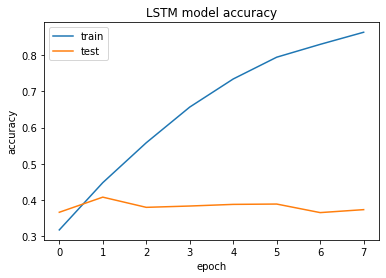

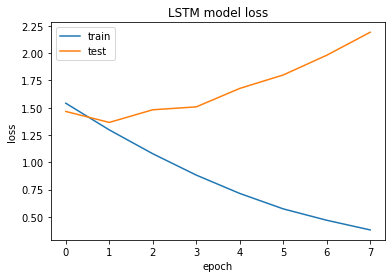

In [0]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
from keras.callbacks import ModelCheckpoint

mcp1 = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)


bs = 64
n_epochs = 8

x_train = sst_train_data_one_hot_padded
y_train = np.array(sst_train_labels).astype(int)
x_dev = sst_dev_data_one_hot_padded
y_dev = np.array(sst_dev_labels).astype(int)

#y_train = to_categorical(sst_train_labels)
#y_val = to_categorical(sst_dev_labels)

want_train =True
if want_train:
    #history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))
    history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev), callbacks = [mcp1])

#plotting

# plotting accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plotting loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
sst_test_LSTM_pred = model.predict_classes(sst_test_data_one_hot_padded)
np.savetxt('logreg_lstm_y_test_sst.txt', sst_test_LSTM_pred, fmt='%s')

## 4.3 - innovate !

In [0]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

#importation

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing import text
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, MaxPooling1D, Embedding, Dropout, Flatten, Bidirectional, Reshape, Conv2D, MaxPool2D

#prepare data
need_to_prepare_data = True

if need_to_prepare_data:
    unique_word = np.unique(sum([sent.split() for sent in sst_train_data + sst_dev_data + sst_test], []))
    num_words = unique_word.shape[0]

    tokenizer = text.Tokenizer(num_words = num_words)
    tokenizer.fit_on_texts(sst_train_data + sst_dev_data + sst_test)

    #X_train = pad_sequences(tokenizer.texts_to_sequences(sst_train_data), maxlen = 50)
    #X_val = pad_sequences(tokenizer.texts_to_sequences(sst_dev_data), maxlen = 50)
    #X_test = pad_sequences(tokenizer.texts_to_sequences(sst_test), maxlen = 50)

    X_train = pad_sequences(tokenizer.texts_to_sequences(sst_train_data))
    X_val = pad_sequences(tokenizer.texts_to_sequences(sst_dev_data))
    X_test = pad_sequences(tokenizer.texts_to_sequences(sst_test))

#create embeddings matrix
need_to_build_embed_matrix = True

if need_to_build_embed_matrix :
    w2v = Word2Vec(wiki_news_path, vocab_size=2000000)
    word_idx = tokenizer.word_index
    my_num_words = len(word_idx) + 1
    embed_mat = np.zeros((my_num_words, 300))

    for word, i in word_idx.items():
        if word in w2v.words:
            embed_mat[i] = w2v.embeddings[w2v.word2id[word]]

#define model
def Bi_LSTM_model(n_classes = 5):

    model = Sequential()
    model.add(Embedding(my_num_words, 300, weights = [embed_mat]))
    #model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(300, return_sequences = True), merge_mode = 'sum'))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(30))
    model.add(Dense(n_classes, kernel_regularizer=l2(0.7e-1),activation='softmax'))
    
    return model
#
loss_classif     =  'sparse_categorical_crossentropy'
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

#
bi_model = Bi_LSTM_model()

print(bi_model.summary())

bi_model.compile(loss = loss_classif,
                  optimizer = optimizer,
                  metrics = metrics_classif)

need_to_train_bi_lstm_model = True
if need_to_train_bi_lstm_model:
    bs = 80
    n_epochs = 4
    
    y_train = np.array(sst_train_labels).astype(int)
    y_val = np.array(sst_dev_labels).astype(int)

    checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose = 1, monitor = 'val_loss',save_best_only = True, mode = 'auto') 
    
    history = bi_model.fit(X_train, y_train, batch_size = bs, epochs = n_epochs, validation_data = (X_val, y_val), callbacks = [checkpoint])

Loaded 999994 pretrained word vectors
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         5352000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 300)         1442400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 5)           645       
Total params: 6,987,173
Trainable params: 6,987,173
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8480/8544

In [0]:
#prediction on test set:
bi_model.load_weights("model-002.h5")
sst_test_bidirect_LSTM_pred = bi_model.predict_classes(X_test)
np.savetxt('bidirectional_lstm_y_test_sst.txt', sst_test_bidirect_LSTM_pred, fmt='%s')